<a href="https://colab.research.google.com/github/waelrash1/predictive_analytics_DT302/blob/main/Lab_gradient_boosting_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Boosting Machines (GBMs) with XGBoost

This tutorial is a part of [Machine Learning with Python: Zero to GBMs](https://zerotogbms.com) and [Zero to Data Science Bootcamp by Jovian](https://zerotodatascience.com)

![](https://i.imgur.com/6MYc56a.png)


The following topics are covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Let's begin by installing the required libraries.

In [1]:
!pip install numpy pandas matplotlib seaborn --quiet

In [ ]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

     |████████████████████████████████| 68 kB 6.0 MB/s 
     |████████████████████████████████| 173.5 MB 61 kB/s 
     |████████████████████████████████| 2.0 MB 47.0 MB/s 


## Problem Statement

This tutorial takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

## Downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to [accept the competition rules](https://www.kaggle.com/c/rossmann-store-sales/rules) before executing the following cell.

In [2]:
 import pandas as pd
 from sklearn.model_selection import train_test_split
 url='https://raw.githubusercontent.com/selva86/datasets/master/Carseats.csv'
df3 = pd.read_csv(url)
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [3]:
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]

df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In [4]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

Let's load the data into Pandas dataframes.

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

> **EXERCISE**: Can you describe in your own words how a gradient boosting machine is different from a random forest?


For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)



### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [5]:
from xgboost import XGBRegressor,XGBClassifier

In [6]:
?XGBClassifier

In [18]:
model = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=2)

Let's train the model using `model.fit`.

In [19]:
%%time
model.fit(X_train, y_train)

CPU times: user 19.4 ms, sys: 1.87 ms, total: 21.2 ms
Wall time: 16 ms


XGBClassifier(max_depth=2, n_estimators=20, n_jobs=-1, random_state=42)

> **EXERCISE**: Explain how the `.fit` method of `XGBRegressor` applies the iterative machine learning workflow to train the model using the training data.
> 
> <img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [20]:
preds = model.predict(X_train)

In [21]:
preds

array([1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1])

### Evaluation

Let's evaluate the predictions using RMSE error.

In [22]:
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       236
           1       0.84      0.63      0.72       164

    accuracy                           0.80       400
   macro avg       0.81      0.77      0.78       400
weighted avg       0.80      0.80      0.79       400



In [23]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79       118
           1       0.75      0.50      0.60        82

    accuracy                           0.73       200
   macro avg       0.73      0.69      0.69       200
weighted avg       0.73      0.72      0.71       200



### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [24]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

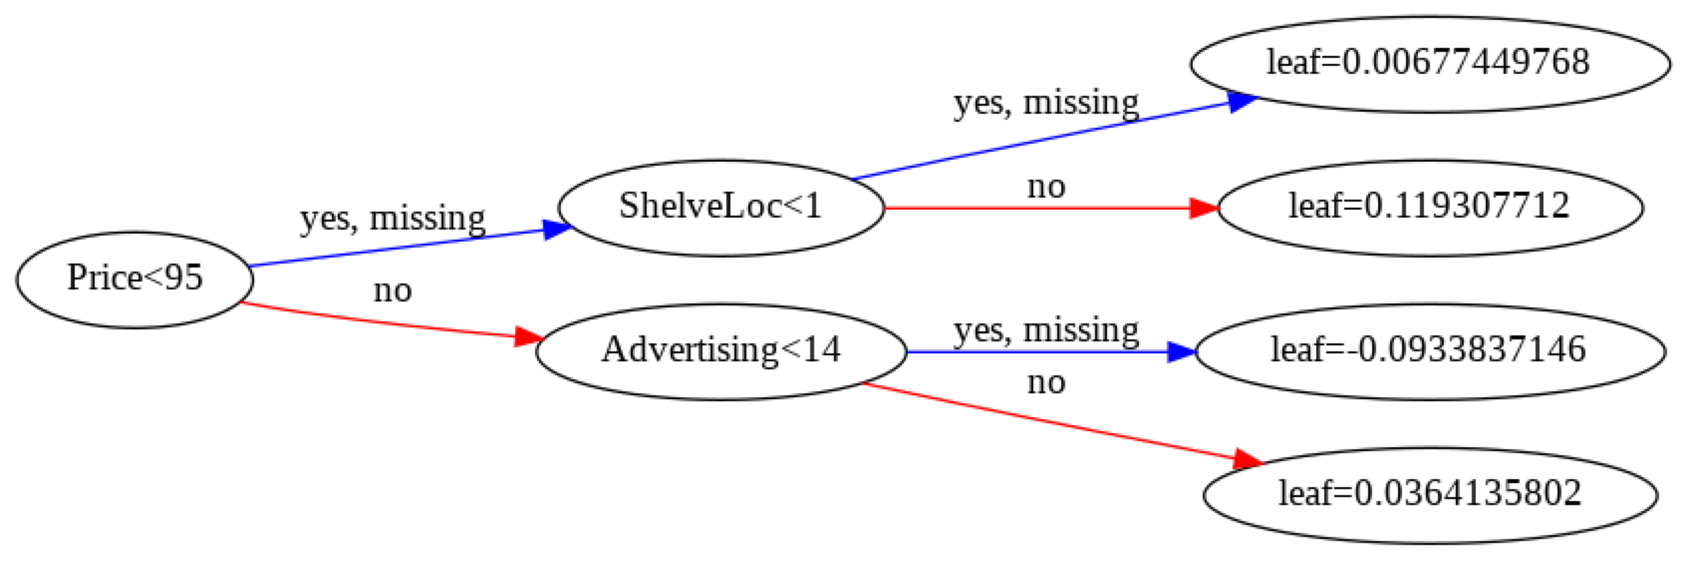

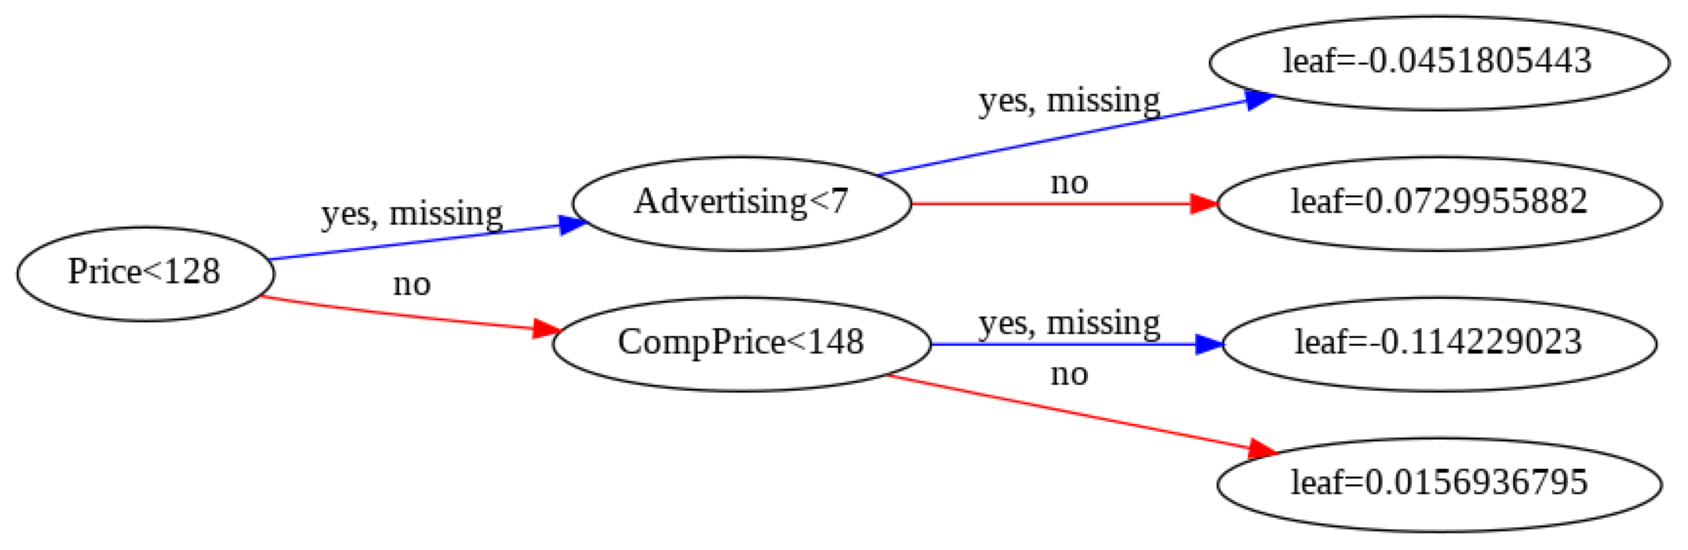

In [25]:
plot_tree(model, rankdir='LR', num_trees=1);
plot_tree(model, rankdir='LR', num_trees=5);

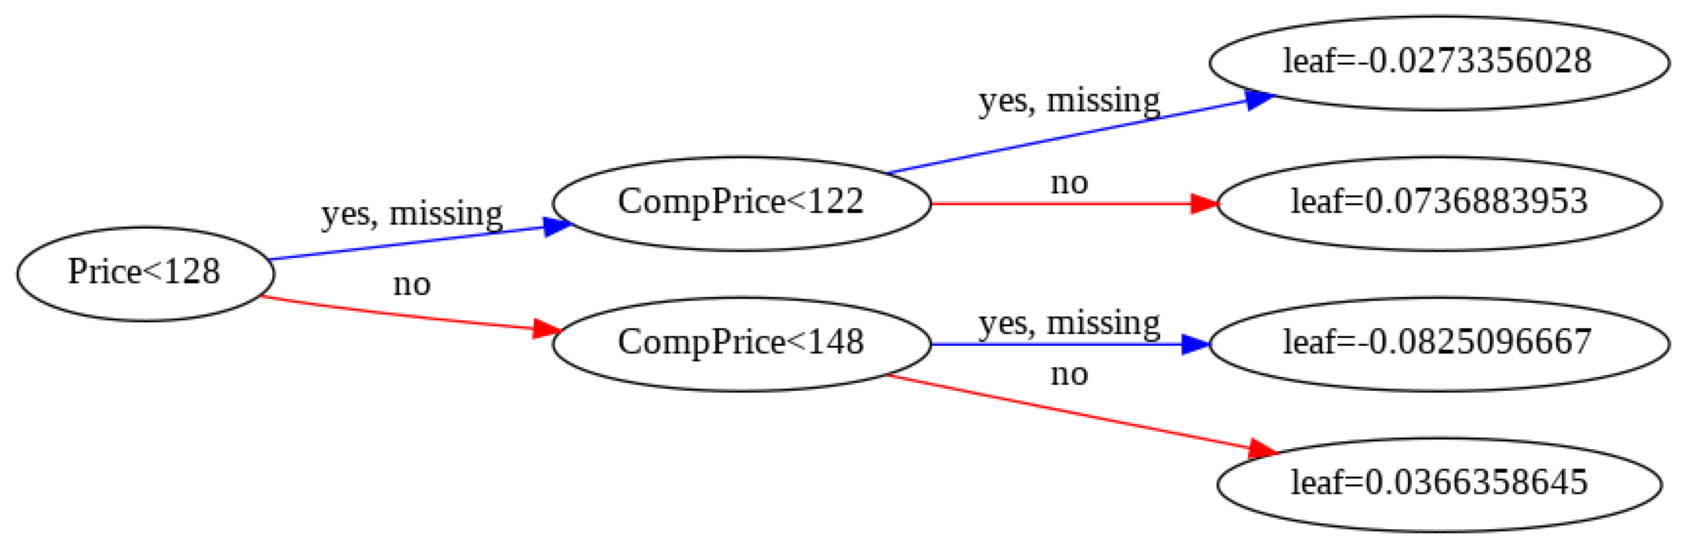

In [26]:
plot_tree(model, rankdir='LR', num_trees=19);

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [27]:
trees = model.get_booster().get_dump()

In [28]:
len(trees)

20

In [29]:
print(trees[0])

0:[Price<95] yes=1,no=2,missing=1
	1:[Age<56] yes=3,no=4,missing=3
		3:leaf=0.140740737
		4:leaf=0.0285714306
	2:[Advertising<14] yes=5,no=6,missing=5
		5:leaf=-0.103124999
		6:leaf=0.0400000028



### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [30]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df.head(10)

,feature,importance
4,Price,0.205159
2,Advertising,0.170657
5,ShelveLoc,0.141906
6,Age,0.114426
0,CompPrice,0.106138
1,Income,0.091515
3,Population,0.065373
7,Education,0.053114
9,US,0.030876
8,Urban,0.020836


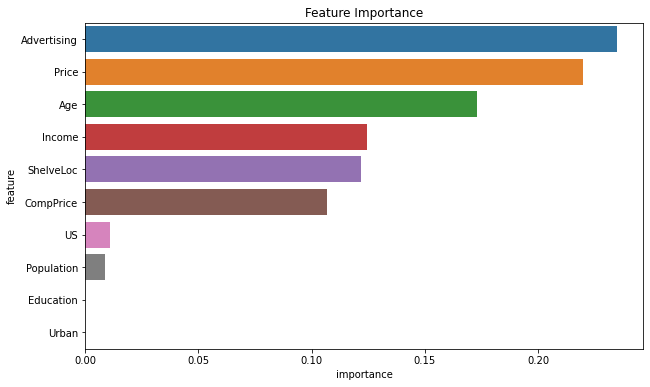

In [31]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Let's save our work before continuing.

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

Scikit-learn provides utilities for performing K fold cross validation.

In [32]:
from sklearn.model_selection import KFold

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [42]:
def rmse (yhat,yactual):
  from sklearn.metrics import mean_squared_error
  from math import sqrt
  return sqrt(mean_squared_error(yhat,yactual))

def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1,objective='reg:squarederror', **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [44]:
kfold = KFold(n_splits=10)

In [72]:
models = []
validations_rsme = []
trainings_rmse= []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    validations_rsme.append(val_rmse)
    trainings_rmse.append(train_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))
    

Train RMSE: 0.2603861833590146, Validation RMSE: 0.36802724787706886
Train RMSE: 0.25936710702867544, Validation RMSE: 0.3643266950336046
Train RMSE: 0.25484646738065736, Validation RMSE: 0.40642353948930926
Train RMSE: 0.25634986070502563, Validation RMSE: 0.3863428178665462
Train RMSE: 0.2660977247749027, Validation RMSE: 0.32822572366580594
Train RMSE: 0.26465274228441016, Validation RMSE: 0.34914301008343845
Train RMSE: 0.2577058511837137, Validation RMSE: 0.36756700344619236
Train RMSE: 0.2531263769053745, Validation RMSE: 0.40339910388200967
Train RMSE: 0.25306765297331496, Validation RMSE: 0.4035726794990379
Train RMSE: 0.26401319843589593, Validation RMSE: 0.3713679567837673


In [73]:
from statistics import mean
mean(trainings_rmse),mean(validations_rsme)

(0.2589613165030985, 0.37483957776267807)

Let's also define a function to average predictions from the 5 different models.

In [59]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [60]:
preds = predict_avg(models, X)

In [61]:
preds

array([0.38944167, 0.88114625, 0.8330878 , 0.360578  , 0.10791441,
       0.832812  , 0.16012968, 0.91541064, 0.1949811 , 0.19788438,
       0.5855814 , 0.6730951 , 0.04164619, 0.8606148 , 0.76537454,
       0.42912692, 0.15766576, 0.82990825, 0.95037997, 0.61849344,
       0.19389477, 0.82370394, 0.18100731, 0.07757952, 0.6999211 ,
       0.91359395, 0.69367474, 0.18357757, 0.10999747, 0.22638163,
       0.96091163, 0.48540172, 0.30988067, 0.6684846 , 0.13978216,
       0.87376136, 0.5476991 , 0.11152456, 0.12878121, 0.09873023,
       0.0712138 , 0.24033478, 0.7755126 , 0.2155681 , 0.18260802,
       0.10384686, 0.94299537, 0.13123071, 0.03008836, 0.6269244 ,
       0.08665707, 0.07343526, 0.23800144, 0.29584825, 0.17017877,
       0.14986433, 0.9232222 , 0.07466009, 0.19651045, 0.06331309,
       0.6777405 , 0.23665348, 0.07283954, 0.5675975 , 0.48044854,
       0.05814946, 0.7533712 , 0.71923995, 0.86319906, 0.25162652,
       0.7455659 , 0.19341336, 0.20487471, 0.85590917, 0.42054

We can now use `predict_avg` to make predictions for the test set.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [62]:
model

XGBRegressor(max_depth=4, n_estimators=20, n_jobs=-1,
             objective='reg:squarederror', random_state=42)

In [74]:
?XGBRegressor

Here's a helper function to test hyperparameters with K-fold cross validation.

In [75]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [76]:
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_val, train_targets, val_targets = train_test_split(X, y, test_size=0.1)

In [81]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42,objective='reg:squarederror', **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.


In [82]:
test_params(n_estimators=10)

Train RMSE: 0.3833663567370354, Validation RMSE: 0.41403182450686354


In [83]:
test_params(n_estimators=30)

Train RMSE: 0.2819949673996299, Validation RMSE: 0.3526534505305162


In [84]:
test_params(n_estimators=100)

Train RMSE: 0.19099394129546737, Validation RMSE: 0.37130112154773875


In [85]:
test_params(n_estimators=240)

Train RMSE: 0.12547643568934466, Validation RMSE: 0.3833233422261443


> **EXERCISE**: Experiment with different values of `n_estimators`, plot a graph of the training and validation error and determine the best value for `n_estimators`.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [86]:
test_params(max_depth=2)

Train RMSE: 0.26336391646966933, Validation RMSE: 0.36239713838073745


In [87]:
test_params(max_depth=5)

Train RMSE: 0.06582156448468496, Validation RMSE: 0.3800928195625566


In [88]:
test_params(max_depth=10)

Train RMSE: 0.0009691339263315473, Validation RMSE: 0.362683124725271


> **EXERCISE**: Experiment with different values of `max_depth`, plot a graph of the training and validation error and determine the optimal.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)

In [90]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 0.24213201559309666, Validation RMSE: 0.3527701898352574


In [91]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 0.16517553505964344, Validation RMSE: 0.37491254875860597


In [92]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 0.06290513027588444, Validation RMSE: 0.4214021888977632


In [93]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 0.06330795116428387, Validation RMSE: 0.3905402743925108


> **EXERCISE**: Experiment with different values of `learning_rate`, plot a graph of the training and validation error and determine the optimal.
> 
> <img src="https://i.imgur.com/EJCrSZw.png" width="360">

#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [94]:
test_params(booster='gblinear')

Train RMSE: 0.43545796119224217, Validation RMSE: 0.4009197373910454


Clearly, a linear model is not well suited for this dataset.

> **EXERCISE**: Exeperiment with other hyperparameters like `gamma`, `min_child_weight`, `max_delta_step`, `subsample`, `colsample_bytree` etc. and find their optimal values. Learn more about them here: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

> **EXERCISE**: Train a model with your best hyperparmeters and evaluate its peformance using 5-fold cross validation.

Let's save our work before continuing.

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [98]:
model = XGBRegressor(n_jobs=-1, random_state=42,objective='reg:squarederror', n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [99]:
%%time
model.fit(X, y)

CPU times: user 632 ms, sys: 7.5 ms, total: 640 ms
Wall time: 540 ms


XGBRegressor(colsample_bytree=0.7, learning_rate=0.2, max_depth=10,
             n_estimators=1000, n_jobs=-1, objective='reg:squarederror',
             random_state=42, subsample=0.9)

Now that the model is trained, we can make predictions on the test set.

In [100]:
test_preds = model.predict(X_test)

## Summary and References

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

The following topics were covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Check out these resources to learn more: 

- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://www.kaggle.com/xwxw2929/rossmann-sales-top1
